In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
import timeit


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

In [3]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
def evaluate_model(model,X,y):
    yhat = model.predict(X)
    yhat_proba = model.predict_proba(X)
    result_dict = {}
    result_dict['accuracy'] = [accuracy_score(y,yhat)]
    result_dict['precision'] = [precision_score(y,yhat)]
    result_dict['recall'] = [recall_score(y,yhat)]
    result_dict['f1_score'] = [f1_score(y,yhat)]
    result_dict['auc'] = [roc_auc_score(y,yhat_proba[:,1])]
    
    df = pd.DataFrame.from_dict(result_dict)
    return df

In [4]:
random_seed = 108
test_size = 0.2

In [5]:
orig_data = pd.read_csv('MASTER STEMI database 2010 - 2019.csv')

In [6]:
cols = [
    'Age',
    'Sex (0 = Male, 1=Female)',
    'Height',
    'Weight',
    'BMI',
    'Hypertension', 
    'Hypercholesterolaemia',
    'Smoking History( 2= current, 1 = ex smoke, 0 = never)', 
    'Diabetes',
    'Family History',
    'Previous stent',
    'Coded Cuplrit Vessel (RCA = 1, LCx = 2, LAD = 3)',
    'TIMI flow pre', 
    'TIMI Flow post',
    'Rentrop Simplified',
    'Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)',
    'No. of stent',
    'Length of stent',
    'CTO in remote vessel',
    'Pre-Hospital Arrest',
    'GP IIb/IIIa inhibitor', 
    'Inotrope during case', 
    'Starting HR',
    'Starting SBP',
    'Arrhythmia during case', 
    'IABP/ECMO',
    'Time from onset to angio (Hrs)',
    'LVEF FINAL',
    'lvef_abnormal'
]

orig_data['LVEF FINAL'] = orig_data['LVEF FINAL'].replace([-55,-99],np.NaN)

orig_data["lvef_abnormal"] = [np.NaN if np.isnan(x) else 1 if x < 40 else 0 for x in orig_data['LVEF FINAL']]

predictors = ['Outcome']

df = orig_data[cols + predictors]

In [7]:
df = df.replace([-55,-99],np.NaN)

for c in df.columns:
    df[c] = df[c].replace('', np.NaN)
    df[c] = df[c].replace('-', np.NaN)
    df[c] = df[c].replace('[a-zA-Z]+', np.NaN).astype(float)
    
df["Height"] = df["Height"].replace(0,np.NaN)
df["Age"] = df["Age"].where(df.Age.between(16, 105)) # remove ages less than 16 and greater than 105

df['Time from onset to angio (Hrs)'] = df['Time from onset to angio (Hrs)'].where(df['Time from onset to angio (Hrs)'] >= 0) 

In [8]:
df["log_length_stent"] = np.log(df['Length of stent'])
df["log_onset_to_angio"] = np.log(df['Time from onset to angio (Hrs)'])
#df.drop(['Length of stent','Time from onset to angio (Hrs)'],axis = 1,inplace=True)

In [9]:
df_subset_index = {}
for p in predictors:
    df_subset_index[p] = df.index[df[p].notna()].tolist()

In [10]:
float_col = [
    'Age',
    'Height',
    'Weight',
    'BMI',
    'Length of stent',
    'log_length_stent',
    'Starting HR',
    'Starting SBP',
    'Time from onset to angio (Hrs)',
    'log_onset_to_angio',
    'No. of stent',
     'LVEF FINAL',
]
categorical_col = [c for c in df.columns if c not in float_col + predictors]

In [13]:
np.max(df['LVEF FINAL'])

60.0

In [11]:
df_dummy.columns
df_dummy_cat_cols = [x for x in df_dummy.columns if x not in float_col + predictors]

NameError: name 'df_dummy' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

train,test = {},{}
for p in predictors:
    train[p],test[p]= train_test_split(df_subset_index[p], test_size=test_size, random_state=random_seed)

In [13]:
final_result_df = pd.read_csv("result/final_out_1year.csv")

In [14]:
final_result_df

,model,accuracy,precision,recall,f1_score,auc,outcome,oversample,n_feature
0,ada,0.680965,0.251852,0.653846,0.363636,0.742152,Outcome,1.0,5.0
1,ada,0.860590,0.000000,0.000000,0.000000,0.772346,Outcome,False,5.0
2,ada,0.680965,0.240310,0.596154,0.342541,0.738468,Outcome,True,10.0
3,ada,0.860590,0.500000,0.173077,0.257143,0.786005,Outcome,False,10.0
4,ada,0.739946,0.277228,0.538462,0.366013,0.729272,Outcome,True,15.0
...,...,...,...,...,...,...,...,...,...
103,logistic,0.857909,0.466667,0.134615,0.208955,0.814821,Outcome,False,20.0
104,logistic,0.737265,0.244444,0.423077,0.309859,0.704649,Outcome,True,25.0
105,logistic,0.857909,0.466667,0.134615,0.208955,0.812725,Outcome,False,25.0
106,logistic,0.742627,0.244186,0.403846,0.304348,0.700575,Outcome,True,30.0


### Generate table 1

In [16]:
cont_describe = df[float_col].describe()

In [17]:
cont_describe = pd.concat([cont_describe,pd.DataFrame(df[float_col].isna().sum()).T]).rename(index={0:'NA'})
cont_describe.loc['NA_perc',:] = cont_describe.loc['NA',:]/df.shape[0]*100

In [18]:
cont_describe

,Age,Height,Weight,BMI,Length of stent,log_length_stent,Starting HR,Starting SBP,Time from onset to angio (Hrs),log_onset_to_angio,No. of stent
count,1863.000000,1786.000000,1849.000000,1762.000000,1714.000000,1714.000000,1851.000000,1846.000000,1657.000000,1657.000000,1863.000000
mean,64.897962,166.477245,78.994214,27.266533,30.053092,3.287744,79.828201,122.682015,8.075405,1.474596,1.160494
std,13.724473,38.441907,24.813583,4.804756,16.101730,0.465309,19.898681,28.185260,10.949759,1.041507,0.635933
min,24.076660,-99.000000,-99.000000,13.000000,6.000000,1.791759,30.000000,34.000000,0.316667,-1.149906,0.000000
25%,54.956879,165.000000,70.000000,24.000000,18.000000,2.890372,66.000000,103.250000,1.983333,0.684779,1.000000
50%,64.536619,172.000000,80.000000,27.000000,26.000000,3.258097,78.000000,121.000000,3.500000,1.252763,1.000000
75%,74.904860,178.000000,90.000000,30.000000,38.000000,3.637586,92.000000,141.000000,8.616667,2.153698,1.000000
max,102.915811,200.000000,172.000000,53.254438,112.000000,4.718499,170.000000,231.000000,77.200000,4.346399,5.000000
NA,0.000000,77.000000,14.000000,101.000000,149.000000,149.000000,12.000000,17.000000,206.000000,206.000000,0.000000
NA_perc,0.000000,4.133119,0.751476,5.421363,7.997853,7.997853,0.644122,0.912507,11.057434,11.057434,0.000000


In [19]:
cont_describe.to_csv("result/data/continuous_variable_summary.csv")

In [14]:
import re
for c in predictors:
    df_sub = pd.concat([
        df[c].value_counts(dropna=False),
        df[c].value_counts(dropna=False,normalize=True)*100,
    ]
    ,axis=1).sort_index()
    df_sub.to_csv("result/data/" + re.sub('[^A-Za-z0-9]+', '', c) + "_summary.csv")

C:\Users\harri\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\harri\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


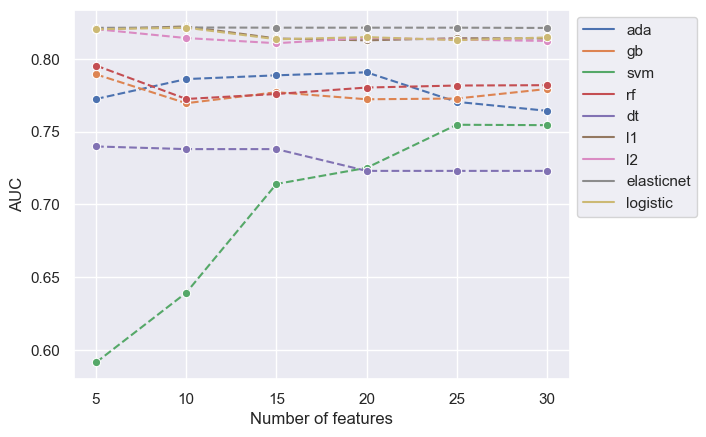

In [23]:

# generate AUC curves against n of features
for p in predictors:
    f,ax = plt.subplots()
    #for m in final_result_df["model"].unique():
    df_sub = final_result_df.query("outcome == @p and oversample == 'False'")
    ax = sns.lineplot(df_sub,x = 'n_feature',y='auc',hue='model',ax=ax,marker='o',linestyle ='--')
    ax.set_xlabel('Number of features')
    ax.set_ylabel('AUC')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.savefig("paper_figure/n_feature_plot_" + p +".png",bbox_inches="tight")

## Probability calibration

In [38]:
df.drop(['Length of stent','Time from onset to angio (Hrs)'],axis = 1,inplace=True)
df_dummy =  pd.get_dummies(
        df,
        columns = categorical_col, 
        dummy_na=False,
        drop_first=True)

In [39]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay
import os
dir = 'C:\\Users\\Harrison Nguyen\\Documents\\CardiacCovidModel\\stemi\\'

In [40]:
model_dict = {
    #'In-Hospital Mortality':"model\\elasticnet_feature_selection5_oversample_In-Hospital Mortality.pickle",
    #'lvef_abnormal':"model\\elasticnet_feature_selection5_oversample_lvef_abnormal.pickle",
    #'ICU admission':"model\\elasticnet_feature_selection5_oversample_ICU admission.pickle"
    'Outcome':"model\\elasticnet_feature_selection5_Outcome.pickle"
}

No calibration: 0.101
With isotonic calibration: 0.101
With sigmoid calibration: 0.099


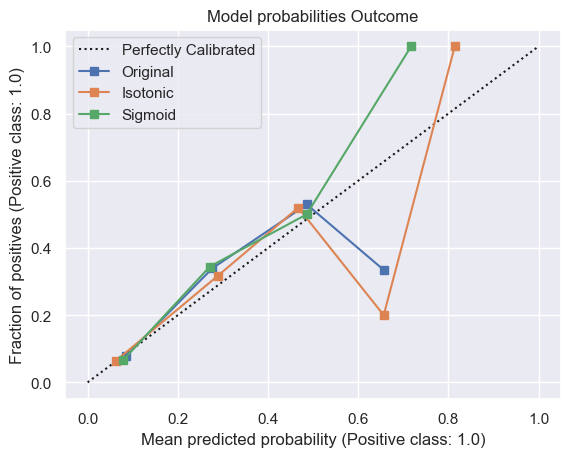

In [41]:
model_name = 'elasticnet_feature_selection5_oversample'
for k,v in model_dict.items():
    p = k
    pipe = joblib.load(v)
    y_train = df_dummy.loc[train[p],p]
    X_train = df_dummy.iloc[train[p]].drop(predictors, axis=1)
    
    clf_isotonic = CalibratedClassifierCV(pipe, cv=5, method="isotonic")
    clf_isotonic.fit(X_train, y_train)
    
    joblib.dump(clf_isotonic,"model/" + model_name + "_" + k + "_isotonic_calibration" +".pickle")

    clf_sigmoid = CalibratedClassifierCV(pipe, cv=5, method="sigmoid")
    clf_sigmoid.fit(X_train, y_train)
    joblib.dump(clf_sigmoid,"model/" + model_name + "_" + k + "_sigmoid_calibration" +".pickle")


    y_test = df_dummy.loc[test[p],p]
    X_test = df_dummy.iloc[test[p]].drop(predictors, axis=1)

    prob_pos_clf = pipe.predict_proba(X_test)[:, 1]
    clf_score = brier_score_loss(y_test, prob_pos_clf)
    print("No calibration: %1.3f" % clf_score)

    prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
    clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic)
    print("With isotonic calibration: %1.3f" % clf_isotonic_score)

    prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]
    clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid)
    print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)
    
    f,ax = plt.subplots()
    CalibrationDisplay.from_estimator(pipe, X_test, y_test,ax=ax)
    CalibrationDisplay.from_estimator(clf_isotonic, X_test, y_test,ax=ax)
    CalibrationDisplay.from_estimator(clf_sigmoid, X_test, y_test,ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["Perfectly Calibrated","Original","Isotonic","Sigmoid"])
    ax.set_title("Model probabilities " + p)
    
    plt.savefig("paper_figure/calibration_plot_" + p +".png",bbox_inches="tight")

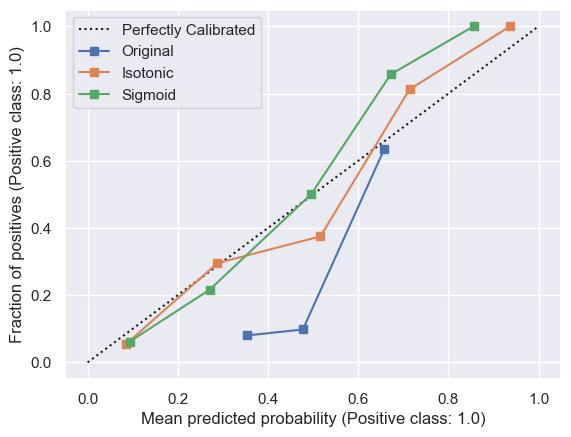

In [42]:
### double check calibration doesn't change auc metric
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
model_name = 'elasticnet_feature_selection5_oversample'
for k,v in model_dict.items():
    print(k)
    p = k
    pipe = joblib.load(v)
    y_test = df_dummy.loc[test[p],p]
    X_test = df_dummy.iloc[test[p]].drop(predictors, axis=1)
    
    yhat_proba = pipe.predict_proba(X_test)
    print(roc_auc_score(y_test,yhat_proba[:,1]))
          
    iso_pipe = joblib.load("model/" + model_name + "_" + k + "_isotonic_calibration" +".pickle")
    yhat_proba = iso_pipe.predict_proba(X_test)
    print(roc_auc_score(y_test,yhat_proba[:,1]))
    

    sig_pipe = joblib.load("model/" + model_name + "_" + k + "_sigmoid_calibration" +".pickle")
    yhat_proba = sig_pipe.predict_proba(X_test)
    print(roc_auc_score(y_test,yhat_proba[:,1]))

Outcome
0.8211718188353703
0.8174275101845195
0.822130361849988


### evaluate calbirated model

In [45]:
test_df_calibrated = pd.DataFrame.from_dict(
    {'model': [],
     'calibration':[],
    'accuracy':[],
     'precision':[],
     'recall':[],
     'f1_score':[],
     'auc':[],
     'outcome':[]})

for k,v in model_dict.items():
    p = k
    y_test = df_dummy.loc[test[p],p]
    X_test = df_dummy.iloc[test[p]].drop(predictors, axis=1)
    for c in ["isotonic","sigmoid","none"]:

        model_name = 'elasticnet_feature_selection5_oversample'
        if c == "none":
            test_pipe = joblib.load("model/{}_{}.pickle".format(model_name,p))
        else:
            test_pipe = joblib.load("model/{}_{}_{}_calibration.pickle".format(model_name,p,c))
        test_result_df = evaluate_model(test_pipe,X_test,y_test)
        #print(test_pipe.predict_proba(X_test)[:,1])
        test_result_df["outcome"] = p
        test_result_df["model"] = model_name
        test_result_df["calibration"] = c
        test_result_df["brier_score"] = brier_score_loss(y_test, test_pipe.predict_proba(X_test)[:,1])

        test_df_calibrated = pd.concat([test_df_calibrated,test_result_df],ignore_index=True)
test_df_calibrated.to_csv("result/final_outcome_calibrated_1year.csv")

In [46]:
test_df_calibrated

,model,calibration,accuracy,precision,recall,f1_score,auc,outcome,brier_score
0,elasticnet_feature_selection5_oversample,isotonic,0.855228,0.428571,0.115385,0.181818,0.817428,Outcome,0.100956
1,elasticnet_feature_selection5_oversample,sigmoid,0.849866,0.300000,0.057692,0.096774,0.822130,Outcome,0.099071
2,elasticnet_feature_selection5_oversample,none,0.718499,0.280992,0.653846,0.393064,0.780793,Outcome,0.204919


# auc curves

In [47]:
full_model_dict = {
    'ada': 'adaboost_feature_selection5',
    'gb': 'gb_feature_selection5',
    'svm' : 'svm_feature_selection5',
    'rf': 'rf_feature_selection5',
    'dt': 'decision_feature_selection5',
    'l1': 'l1_feature_selection5',
    'l2': 'l2_feature_selection5_oversample',
    'elasticnet': 'elasticnet_feature_selection5',
    'logistic': 'logistic_feature_selection5',
}

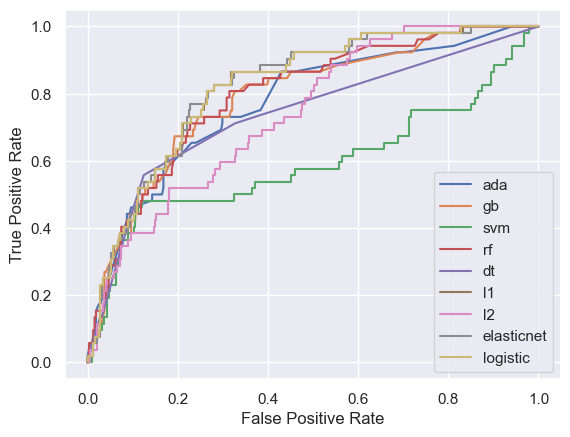

In [48]:
from sklearn import  metrics

for p in predictors:
    f, axs = plt.subplots(1, 1)
    y_test = df_dummy.loc[test[p],p]
    X_test = df_dummy.iloc[test[p]].drop(predictors, axis=1)
    
    
    for k,v in full_model_dict.items():
        model_name = v
        test_pipe = joblib.load("model/" + v + "_" + p +".pickle")
        metrics.RocCurveDisplay.from_estimator(test_pipe, X_test, y_test,name=k,ax=axs) 
        #if v in best_result[best_result["outcome"] == p]["model"].values:
        #    metrics.RocCurveDisplay.from_estimator(test_pipe, X_test, y_test,name=k)
    axs.legend(list(full_model_dict.keys()))
    axs.set_xlabel('False Positive Rate')
    axs.set_ylabel('True Positive Rate')
    plt.savefig("paper_figure/auc_curves_" + p + ".png",bbox_inches="tight")

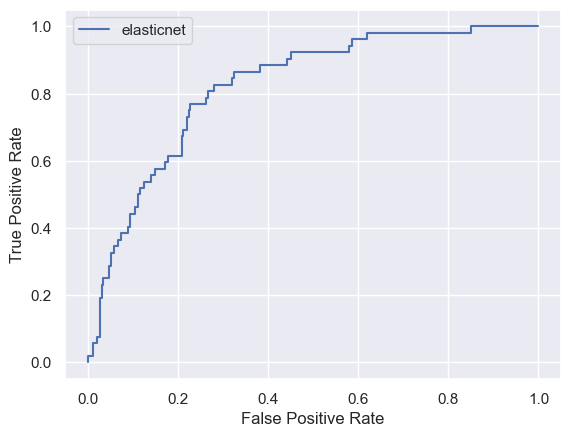

In [49]:
for p in predictors:
    
    y_test = df_dummy.loc[test[p],p]
    X_test = df_dummy.iloc[test[p]].drop(predictors, axis=1)
    
    model_name = model_dict[p]
    test_pipe = joblib.load(model_name)
    f, axs = plt.subplots(1, 1)
    metrics.RocCurveDisplay.from_estimator(test_pipe, X_test, y_test,name=k,ax= axs)
    axs.legend(["elasticnet"])
    axs.set_xlabel('False Positive Rate')
    axs.set_ylabel('True Positive Rate')
    plt.savefig("paper_figure/auc_curves_elasticnet"+ "_"+p+ ".png",bbox_inches="tight")

## Coefficients

In [50]:
def plot_coef(model,model_name,columns,predictor_label,predictor):
    
    if "feature_select" in model.named_steps:
        feature_select = model.named_steps["feature_select"].support_
        columns = columns[feature_select]
        
    coefs = model.named_steps["model"].coef_
    coef_df = pd.DataFrame(data = {'variable' : columns,
                          'Value' : coefs[0],
                           'mag':   coefs[0]    })

    coef_df = coef_df.sort_values('Value', ascending=False)
    plt.figure(figsize=(18, 18))
    ax = sns.barplot(
        data=coef_df, x="variable", y="Value")
    ax.set_title("Coefficient for " + predictor_label)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(), rotation=45)

    plt.savefig("paper_figure/model_coefff_" +predictor+".png",bbox_inches="tight")
    return ax

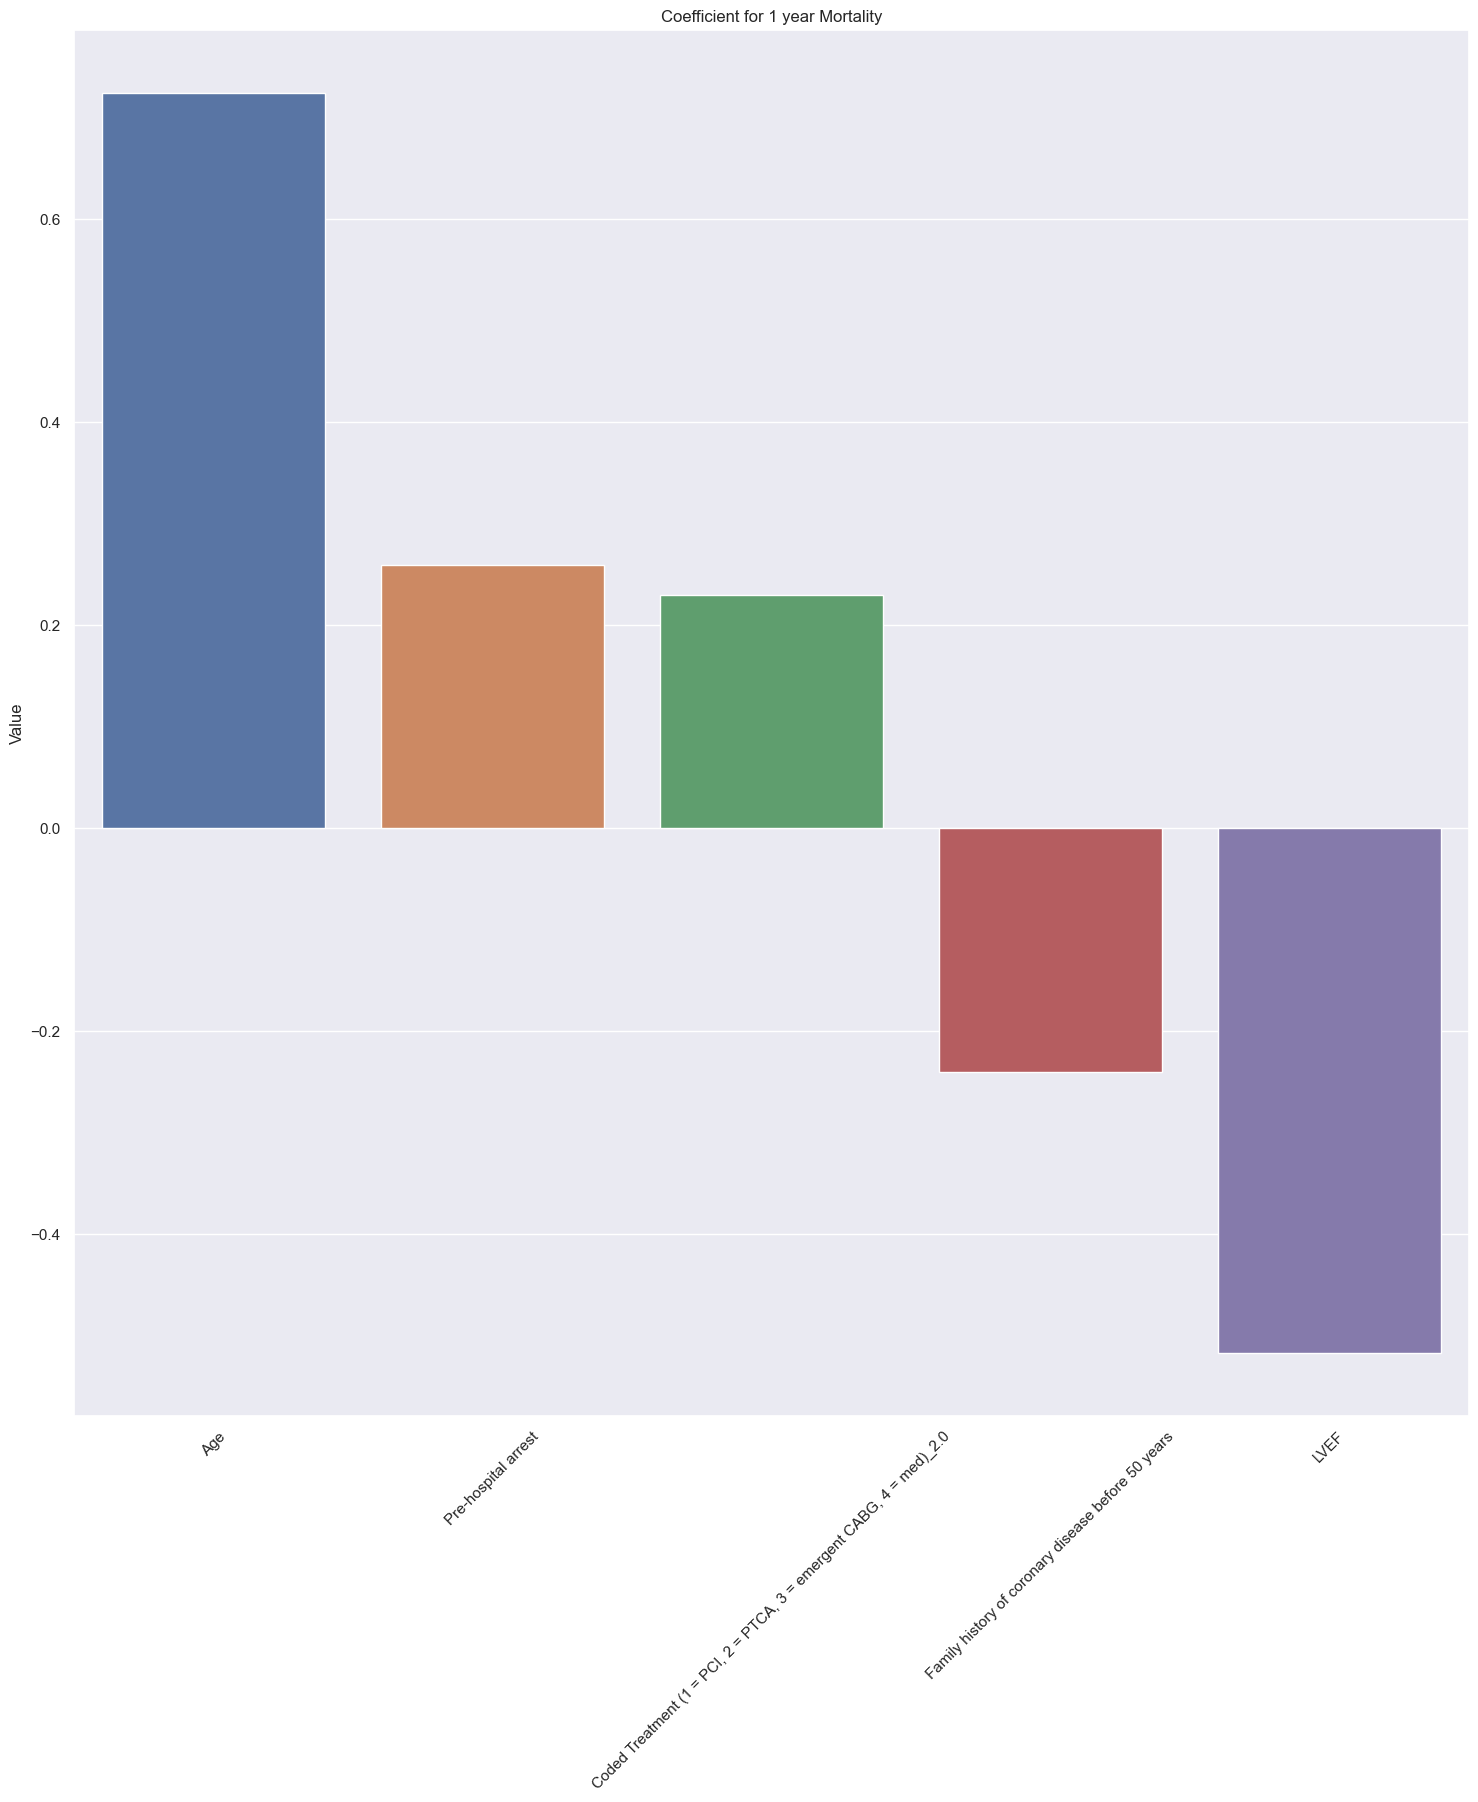

In [56]:
predictor_name = {
    #'lvef_abnormal': 'LVEF < 40%', 
    #'In-Hospital Mortality': 'In-hospital Mortality', 
    #'ICU admission': 'ICU Admission'
    'Outcome': '1 year Mortality'
}
for p in predictors:
    y_test = df_dummy.loc[test[p],p]
    X_test = df_dummy.iloc[test[p]].drop(predictors, axis=1)
    
    X_test_adj = X_test.rename(columns={
        
        'Coded Cuplrit Vessel (RCA = 1, LCx = 2, LAD = 3)_3.0': 'Coded Culprit Vessel (LAD)',
        'Starting SBP': 'Starting syslotic blood pressure (mmHg)',
        'Smoking History( 2= current, 1 = ex smoke, 0 = never)_2.0': 'Smoking History (Never)',
        'TIMI flow pre_2.0': 'TIMI flow of grade 2 at onset of angio',
        'Rentrop Simplified_1.0': 'Robust collateral recruitment',
        'Pre-Hospital Arrest_1.0': 'Pre-hospital arrest',
        'Starting HR':'Starting heart rate (bpm)',
        'Hypercholesterolaemia_1.0': 'Hypercholesterolaemia',
        'Family History_1.0': 'Family history of coronary disease before 50 years', 
        'LVEF FINAL': 'LVEF'  
    })
    
    model_name = model_dict[p]
    test_pipe = joblib.load(model_name)
        
    ax = plot_coef(test_pipe,model_name,X_test_adj.columns,predictor_name[p],p)

In [20]:
model_name

'model\\elasticnet_feature_selection5_oversample_lvef_abnormal.pickle'

In [23]:
X_test.columns

Index(['Age', 'Height', 'Weight', 'BMI', 'No. of stent', 'Starting HR',
       'Starting SBP', 'log_length_stent', 'log_onset_to_angio',
       'Sex (0 = Male, 1=Female)_1.0', 'Hypertension_1.0',
       'Hypercholesterolaemia_1.0',
       'Smoking History( 2= current, 1 = ex smoke, 0 = never)_1.0',
       'Smoking History( 2= current, 1 = ex smoke, 0 = never)_2.0',
       'Diabetes_1.0', 'Family History_1.0', 'Previous stent_1.0',
       'Coded Cuplrit Vessel (RCA = 1, LCx = 2, LAD = 3)_2.0',
       'Coded Cuplrit Vessel (RCA = 1, LCx = 2, LAD = 3)_3.0',
       'TIMI flow pre_1.0', 'TIMI flow pre_2.0', 'TIMI flow pre_3.0',
       'TIMI Flow post_1.0', 'TIMI Flow post_2.0', 'TIMI Flow post_3.0',
       'Rentrop Simplified_1.0',
       'Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_2.0',
       'Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_3.0',
       'Coded Treatment (1 = PCI, 2 = PTCA, 3 = emergent CABG, 4 = med)_4.0',
       'CTO in remote vessel_

In [30]:
predictors

['lvef_abnormal', 'In-Hospital Mortality', 'ICU admission']